In [1]:
import pandas as pd

df = pd.read_csv('../data/AMAZON-REVIEW-DATA-CLASSIFICATION.csv')
df.head()

,reviewText,summary,verified,time,log_votes,isPositive
0,"PURCHASED FOR YOUNGSTER WHO\nINHERITED MY ""TOO...",IDEAL FOR BEGINNER!,True,1361836800,0.000000,1.0
1,unable to open or use,Two Stars,True,1452643200,0.000000,0.0
2,Waste of money!!! It wouldn't load to my system.,Dont buy it!,True,1433289600,0.000000,0.0
3,I attempted to install this OS on two differen...,I attempted to install this OS on two differen...,True,1518912000,0.000000,0.0
4,I've spent 14 fruitless hours over the past tw...,Do NOT Download.,True,1441929600,1.098612,0.0


In [2]:
df["isPositive"].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

In [3]:
print(df.isna().sum())

reviewText    11
summary       14
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  69989 non-null  object 
 1   summary     69986 non-null  object 
 2   verified    70000 non-null  bool   
 3   time        70000 non-null  int64  
 4   log_votes   70000 non-null  float64
 5   isPositive  70000 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.7+ MB
None


In [5]:
print(df.describe())

               time     log_votes    isPositive
count  7.000000e+04  70000.000000  70000.000000
mean   1.370112e+09      0.535257      0.624171
std    1.149986e+08      0.962677      0.484340
min    9.421920e+08      0.000000      0.000000
25%    1.322870e+09      0.000000      0.000000
50%    1.406160e+09      0.000000      1.000000
75%    1.448669e+09      1.098612      1.000000
max    1.538438e+09      7.110696      1.000000


In [6]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravikiran.bhonagiri\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravikiran.bhonagiri\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "log_votes"]],
                                                  df["isPositive"],
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=360
                                                 )

In [9]:
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

Processing the reviewText fields
Processing the summary fields


In [10]:

# Grab model features/inputs and target/output
numerical_features = ['time',
                      'log_votes']

text_features = ['summary',
                 'reviewText']

model_features = numerical_features + text_features
model_target = 'isPositive'

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler())
])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
])

# Preprocess 2nd text feature (larger vocabulary)
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
]) 

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('logistic_regression', LogisticRegression(penalty = 'l2',
                              C = 0.1))
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression', LogisticRegression(C=0.1))])

In [12]:
# Fit the Pipeline to training data
pipeline.fit(X_train, y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression', LogisticRegression(C=0.1))])

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted pipeline to make predictions on the validation dataset
val_predictions = pipeline.predict(X_val)
print(confusion_matrix(y_val.values, val_predictions))
print(classification_report(y_val.values, val_predictions))
print("Accuracy (validation):", accuracy_score(y_val.values, val_predictions))

[[2004  623]
 [ 443 3930]]
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79      2627
         1.0       0.86      0.90      0.88      4373

    accuracy                           0.85      7000
   macro avg       0.84      0.83      0.84      7000
weighted avg       0.85      0.85      0.85      7000

Accuracy (validation): 0.8477142857142858


Highest Accuracy on Validation: 0.8492857142857143 , Threshold for the highest Accuracy: 0.54


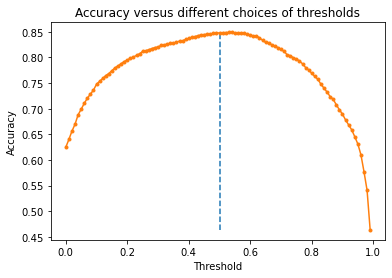

In [14]:

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

# Calculate the accuracy using different values for the classification threshold, 
# and pick the threshold that resulted in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01)
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_val_other = (pipeline.predict_proba(X_val)[:,1] >= t).astype(float)
    score = accuracy_score(y_val, y_val_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t
print("Highest Accuracy on Validation:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)   

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [15]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate the precision and recall using different values for the classification threshold
val_predictions_probs = pipeline.predict_proba(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, val_predictions_probs[:, 1])

Highest F1 score on Validation: 0.8821563822677657 , Threshold for the highest F1 score: 0.4860435225160355


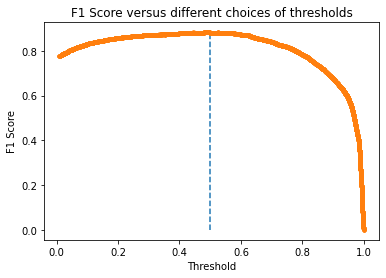

In [16]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

# Calculate the F1 score using different values for the classification threshold, 
# and pick the threshold that resulted in the highest F1 score.
highest_f1 = 0
threshold_highest_f1 = 0

f1_scores = []
for id, threhold in enumerate(thresholds):
    f1_score = 2*precisions[id]*recalls[id]/(precisions[id]+recalls[id])
    f1_scores.append(f1_score)
    if(f1_score > highest_f1):
        highest_f1 = f1_score
        threshold_highest_f1 = threhold
print("Highest F1 score on Validation:", highest_f1, \
      ", Threshold for the highest F1 score:", threshold_highest_f1)

# Let's plot the F1 score versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--')
plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()